In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import rankdata

In [2]:
def process_df(df:pd.DataFrame):
    summ_df = df.copy()
    summ_df['Gene'] = summ_df['Gene'].apply(lambda x: x.split('_')[0]).values
    summ_df.sort_values(['Gene', 'Acc'], ascending=[True, False], inplace=True)
    summ_df.drop_duplicates('Gene', inplace=True)
    summ_df = summ_df.loc[~summ_df['Gene'].isin(['APOE', 'TOMM40', 'APOC1', 'BCAM'])]
    summ_df['-logP'] = -np.log10(summ_df['P'])
    summ_df['Rank'] = rankdata(summ_df['P'])
    return summ_df

In [9]:
metric = '-logP'

## Sensitivity vs GWANNv1

In [4]:
for s in ['1.3', '1.4', '1.5']:
    if s != '1.4':
        summ_df_new = pd.read_csv(f'/home/upamanyu/GWANN/Code_AD/results_Sens{s}/MATERNAL_MARIONI_Sens{s}_summary.csv')
    else:
        summ_df_new = pd.read_csv(f'/home/upamanyu/GWANN/Code_AD/results_Sens{s}/1_MATERNAL_MARIONI_Sens{s}_summary.csv')
    summ_df_new = process_df(summ_df_new)
    summ_df_v1 = pd.read_csv('../../GWASOnSteroids/Results/Annotated_NoDup_MatAD_NN_GWAS.csv')
    summ_df_v1 = process_df(summ_df_v1)
    summ_df_v1.set_index('Gene', inplace=True, drop=False)
    summ_df_v1 = summ_df_v1.loc[summ_df_new['Gene'].values]

    x = summ_df_new[f'{metric}'].values
    y = summ_df_v1[f'{metric}'].values
    sns.regplot(x=x, y=y)
    if metric == '-logP':
        plt.axvline(x=-np.log10(0.05/73310), linestyle=':', linewidth=1, color='r')
        plt.axhline(y=-np.log10(0.05/73310), linestyle=':', linewidth=1, color='r')
    plt.xlabel(f'{metric} when using dosage (Sens{s})')
    plt.ylabel(f'{metric} when using hardcall (-1 as missing)')
    plt.savefig(f'./results_Sens{s}/dosage_vs_hardcall_{metric}.png', dpi=100)
    plt.close()

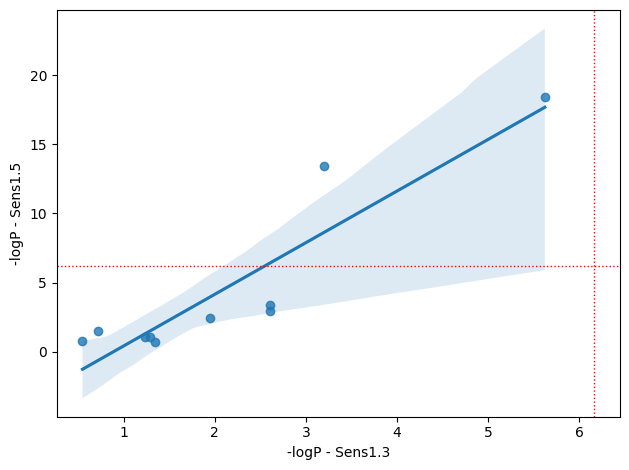

In [10]:
a = 'Sens1.3'
b = 'Sens1.5'
summ_df_a = pd.read_csv(f'/home/upamanyu/GWANN/Code_AD/results_{a}/MATERNAL_MARIONI_{a}_summary.csv')
summ_df_a = process_df(summ_df_a)

summ_df_b = pd.read_csv(f'/home/upamanyu/GWANN/Code_AD/results_{b}/MATERNAL_MARIONI_{b}_summary.csv')
summ_df_b = process_df(summ_df_b)
summ_df_b.set_index('Gene', inplace=True, drop=False)
summ_df_b = summ_df_b.loc[summ_df_a['Gene']]

x = summ_df_a[f'{metric}'].values
y = summ_df_b[f'{metric}'].values
sns.regplot(x=x, y=y)
if metric == '-logP':
    plt.axvline(x=-np.log10(0.05/73310), linestyle=':', linewidth=1, color='r')
    plt.axhline(y=-np.log10(0.05/73310), linestyle=':', linewidth=1, color='r')
plt.xlabel(f'{metric} - {a}')
plt.ylabel(f'{metric} - {b}')

plt.tight_layout()
plt.savefig(f'./results_{a}/{a}_vs_{b}_{metric}.png', dpi=100)


## Sens 1.4

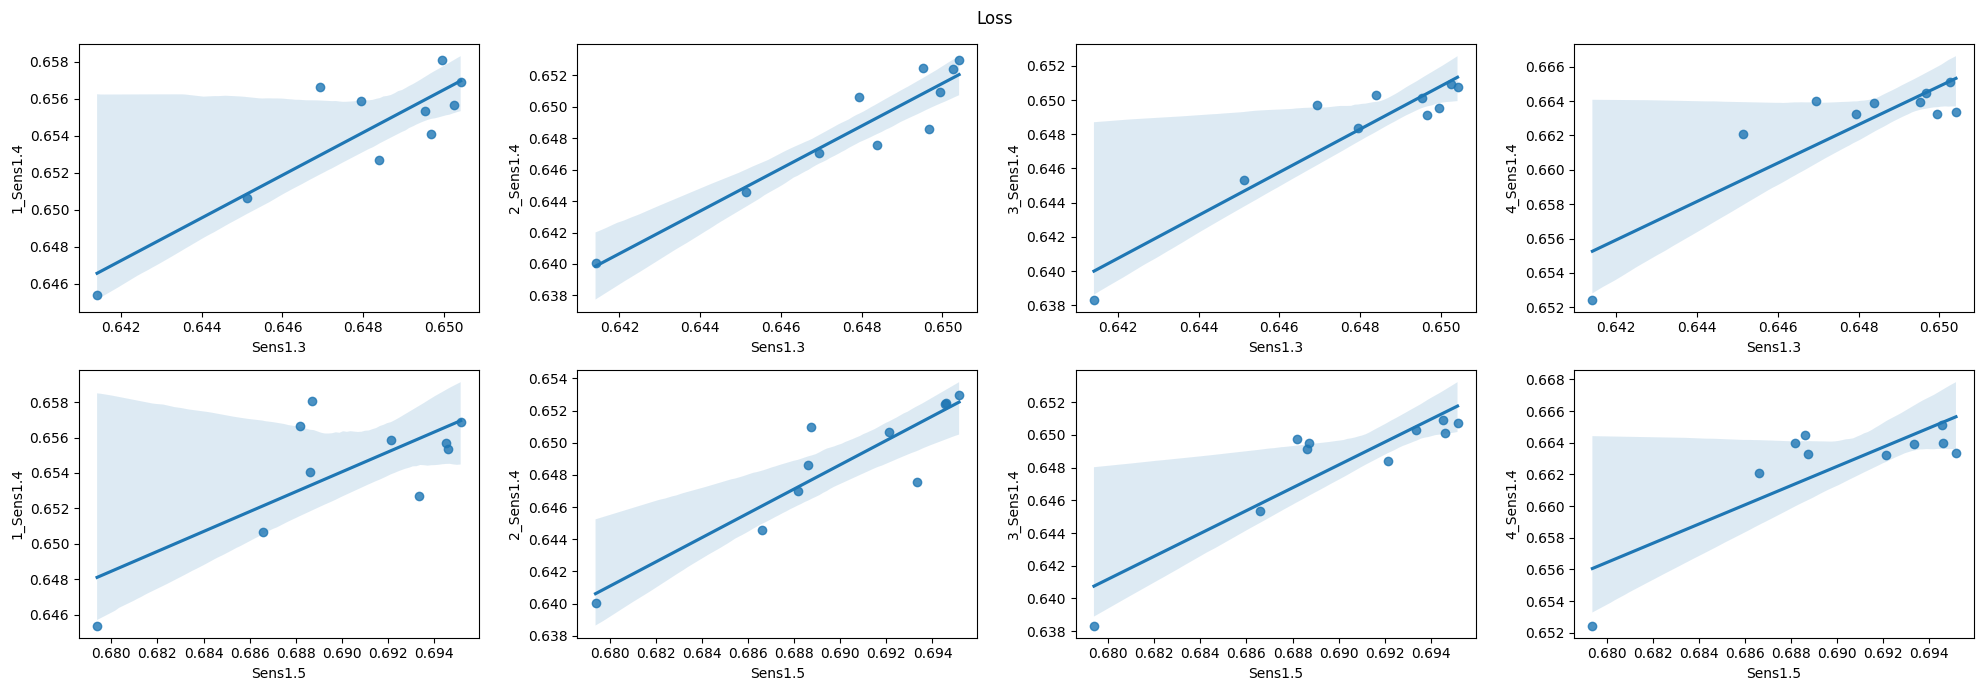

In [10]:
fig, ax = plt.subplots(2, 4, figsize=(20, 7))
ax = ax.flatten()
axi = 0
for sens in ['Sens1.3', 'Sens1.5']:
    for grouping in [1, 2, 3, 4]:
        summ_df_14 = pd.read_csv(f'/home/upamanyu/GWANN/Code_AD/results_Sens1.4/{grouping}_MATERNAL_MARIONI_Sens1.4_summary.csv')
        summ_df_14 = process_df(summ_df_14)
        summ_df_1x = pd.read_csv(f'/home/upamanyu/GWANN/Code_AD/results_{sens}/MATERNAL_MARIONI_{sens}_summary.csv')
        summ_df_1x = process_df(summ_df_1x)
        summ_df_1x.set_index('Gene', inplace=True, drop=False)
        summ_df_1x = summ_df_1x.loc[summ_df_14['Gene']]

        x = summ_df_1x[f'{metric}'].values
        y = summ_df_14[f'{metric}'].values
        # sns.scatterplot(x=x, y=y, ax=ax[axi])
        sns.regplot(x=x, y=y, ax=ax[axi])
        if metric == '-logP':
            ax[axi].axvline(x=-np.log10(0.05/73310), linestyle=':', linewidth=1, color='r')
            ax[axi].axhline(y=-np.log10(0.05/73310), linestyle=':', linewidth=1, color='r')
        ax[axi].set_xlabel(f'{sens}')
        ax[axi].set_ylabel(f'{grouping}_Sens1.4')
        
        axi += 1

fig.suptitle(metric)
fig.tight_layout()
fig.savefig(f'./results_Sens1.4/Sens1.4_vs_Sens1x_{metric}.png', dpi=100)


In [26]:
agg_summ_df = pd.DataFrame(columns=['Gene', 'Acc', 'Loss', '-logP', 'Rank', 'Grouping_id'])
for i in range(1, 5):
    for j in range(i+1, 5):
        dfi = pd.read_csv(f'/home/upamanyu/GWANN/Code_AD/results_Sens1.4/{i}_MATERNAL_MARIONI_Sens1.4_summary.csv')
        dfi = process_df(dfi)
        dfj = pd.read_csv(f'/home/upamanyu/GWANN/Code_AD/results_Sens1.4/{j}_MATERNAL_MARIONI_Sens1.4_summary.csv')
        dfj = process_df(dfj)
        
        x = dfi[f'{metric}'].values
        y = dfj[f'{metric}'].values

        sns.regplot(x=x, y=y)
        if metric == '-logP':
            plt.axvline(x=-np.log10(0.05/73310), linestyle=':', linewidth=1, color='r')
            plt.axhline(y=-np.log10(0.05/73310), linestyle=':', linewidth=1, color='r')
        plt.savefig(f'./results_Sens1.4/effect_of_diff_grouping/{i}vs{j}_{metric}.png', dpi=100)
        plt.close()
